In [65]:
'''
Created on Tue Oct 16 13:33:39 2018
@author: mchini

Modified on 22 May 2020
by Andrey Formozov

The code consists of three parts: 

(1) ALIGNMENT ALGORITHM 
(2) DRAW ALIGNMENT
(3) ROI adjustment check for all recordings,

 where the last two are used to check and validate results by visual inspection (uncommment them if they are necessary). 

ALIGNMENT ALGORITHM provides transformation matricies used for alignment of the ROI's from different recordings with 
consiquent global neuron ID assignment.

The quality of the alignment is calculated as root-mean-square deviation (RMSD) of the corrected images
from the reference one. Both images for RMSD calculation are mean images (not enhanced!). 
Both have 100 pixels truncated from the boarders.

 The alignmnet algorithm is based on pystackreg package

https://pypi.org/project/pystackreg/
https://readthedocs.org/projects/pystackreg/downloads/pdf/latest/

| P. Thevenaz, U.E. Ruttimann, M. Unser
| A Pyramid Approach to Subpixel Registration Based on Intensity
| IEEE Transactions on Image Processing
| vol. 7, no. 1, pp. 27-41, January 1998.

'''

### INPUTS AND OPTIONS

path = '/media/andrey/My Passport/GIN/Anesthesia_CA1/meta_data/meta_recordings - anesthesia.xlsx'
path4results = '/media/andrey/My Passport/GITHUB_REPOS/Yang_Chini_et_al/notebooks/results/' #To store transformation matrisies
save_plots_path = '/media/andrey/My Passport/GITHUB_REPOS/Yang_Chini_et_al/notebooks/results/plots'
log_file_path = save_plots_path + 'registration_logs.txt'

animals_for_analysis = [51]

repeat_calc = 1
silent_mode = False

#######################

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

import sys
np.set_printoptions(threshold=sys.maxsize)

from pystackreg import StackReg

# Sobel filter (not used)
#from scipy import ndimage #https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.sobel.html

meta_data = pd.read_excel(path)

#%% compute transformations matrices between recordings

recordings = meta_data['Number']

animals = animals_for_analysis

#print("Recordings: ", recordings)

#ALIGNMENT ALGORITHM

# log file

f = open(log_file_path, "a")

print("n, i, j, rigid_mean_enh, rigid_mean, affine_mean_enh, affine_mean, best_method ", file=f)

if (silent_mode!=True):
    print(" RMSD's: (rigid, mean_enh) | (rigid, mean) | (affine, mean_enh) | (affine, mean) | best method ")


for animal in animals:
    
    if (silent_mode!=True):
        print("Animal #", str(animal))
    
    
    if not os.path.exists(path4results + 'StackReg/' +
                          str(animal) + '.npy') or repeat_calc == 1:
#    if not os.path.exists('Q:/Personal/Mattia/Calcium Imaging/results/StackRegEnhImage/' +
#                          str(animal) + '.npy') or repeat_calc == 1:
#    if not os.path.exists('Q:/Personal/Mattia/Calcium Imaging/results/StackReg/' +
#                          str(animal) + '.npy') or repeat_calc == 1:
       
        meta_animal = meta_data[meta_data['Mouse'] == animal]
        recordings = meta_animal['Number']
        print(recordings)
        images_mean = np.zeros((512, 512, np.shape(recordings)[0]))
        images_mean_enh = np.zeros((512, 512, np.shape(recordings)[0]))

        images_quality_check = np.zeros((512, 512, np.shape(recordings)[0]))

        best_tmats = np.zeros((np.shape(recordings)[0], np.shape(recordings)[0], 3, 3))
        best_score = np.zeros((np.shape(recordings)[0], np.shape(recordings)[0]))
        best_methods =  np.zeros((np.shape(recordings)[0], np.shape(recordings)[0]))


        tmats_affine = np.zeros((np.shape(recordings)[0], np.shape(recordings)[0], 3, 3))
        tmats_rigid = np.zeros((np.shape(recordings)[0], np.shape(recordings)[0], 3, 3))
        tmats_affine_enh = np.zeros((np.shape(recordings)[0], np.shape(recordings)[0], 3, 3))
        tmats_rigid_enh = np.zeros((np.shape(recordings)[0], np.shape(recordings)[0], 3, 3))

        # load all (enhanced) images
        for idx, recording in enumerate(recordings):
            options = np.load(meta_data['Folder'][recording] + 
                              meta_data['Subfolder'][recording] +
                              str(int(meta_data['Recording idx'][recording])) +
                              '/suite2p/plane0/ops.npy',
                              allow_pickle=True)
        # mean image or mean enhanced image
            images_mean[:, :, idx] = options.item(0)['meanImg']
            images_mean_enh[:, :, idx] = options.item(0)['meanImgE']
            #cut_boarders=50
            #quality check
            images_quality_check[:, :, idx] = options.item(0)['meanImg']


        # loop through every pair and compute the transformation matrix
        
        conditions = [meta_data['Condition'][recording] for recording in recordings]
        
        for idx0 in range(np.shape(images_mean)[2]):
            #if (idx0!=14):
                    #continue
            
            for idx1 in range(idx0, np.shape(images_mean)[2]):
                #if (idx1!=16):
                    #continue
           
                      
                fraction_of_non_zero_pixels = [0.0,0.0,0.0,0.0]
                
### MEAN RIGID and AFFINE

                reference_image = images_mean[:, :, idx0]
                initial_image = images_mean[:, :, idx1]

                #sx = ndimage.sobel(reference_image, axis=0, mode='constant')
                #sy = ndimage.sobel(reference_image, axis=1, mode='constant')
                #reference_image = np.hypot(sx, sy)

                #sx = ndimage.sobel(initial_image, axis=0, mode='constant')
                #sy = ndimage.sobel(initial_image, axis=1, mode='constant')
                #initial_image = np.hypot(sx, sy)

                boarder_cut = 100
                sr = StackReg(StackReg.AFFINE)
                tmats_affine[idx0, idx1, :, :] = sr.register(reference_image, initial_image)
                
                image_transformed =  sr.transform(images_quality_check[:, :, idx1], tmats_affine[idx0, idx1, :, :])
                image_difference = images_quality_check[:, :, idx0] -  image_transformed
                fraction_of_non_zero_pixels[3] = np.count_nonzero(image_transformed[:,:]<0.001)/262144
                #plt.imshow(image_transformed)
                #plt.show()
                image_difference = image_difference[boarder_cut:-boarder_cut, boarder_cut:-boarder_cut]
                image_difference = np.square(image_difference)
                rmsd_affine = np.sqrt(image_difference.sum()/(512 - 2 * boarder_cut)**2)
                if (silent_mode!=True):
                    print("Fraction of non-zero pixels in 3 (mean affine): ", fraction_of_non_zero_pixels[3]," Score:",rmsd_affine)

                sr = StackReg(StackReg.RIGID_BODY)
                tmats_rigid[idx0, idx1, :, :] = sr.register(reference_image, initial_image)
                image_transformed = sr.transform(images_quality_check[:, :, idx1], tmats_rigid[idx0, idx1, :, :])
                image_difference = images_quality_check[:, :, idx0] - image_transformed
                fraction_of_non_zero_pixels[1] = np.count_nonzero(image_transformed[:,:]<0.001)/262144

                #plt.imshow(image_transformed)
                #plt.show()
                image_difference = image_difference[boarder_cut:-boarder_cut, boarder_cut:-boarder_cut]
                image_difference = np.square(image_difference)
                rmsd_rigid = np.sqrt(image_difference.sum()/(512 - 2 * boarder_cut)**2)
                if (silent_mode!=True):
                    print("Fraction of non-zero pixels in 1 (mean rigid): ", fraction_of_non_zero_pixels[1], "Score", rmsd_rigid)

                #plt.imshow(image_difference)


### MEAN_ENH RIGID and AFFINE

                reference_image = images_mean_enh[:, :, idx0]
                initial_image = images_mean_enh[:, :, idx1]

                # sx = ndimage.sobel(reference_image, axis=0, mode='constant')
                # sy = ndimage.sobel(reference_image, axis=1, mode='constant')
                # reference_image = np.hypot(sx, sy)

                # sx = ndimage.sobel(initial_image, axis=0, mode='constant')
                # sy = ndimage.sobel(initial_image, axis=1, mode='constant')
                # initial_image = np.hypot(sx, sy)

                boarder_cut = 100
                sr = StackReg(StackReg.AFFINE)
                tmats_affine_enh[idx0, idx1, :, :] = sr.register(reference_image, initial_image)

                image_transformed = sr.transform(images_quality_check[:, :, idx1], tmats_affine_enh[idx0, idx1, :, :])
                image_difference = images_quality_check[:, :, idx0] - image_transformed  #TODO: delete image quality check! replace it with meanimage 
                fraction_of_non_zero_pixels[2] = np.count_nonzero(image_transformed[:,:]<0.001)/262144

                #plt.imshow(image_transformed)
                #plt.show()
                image_difference = image_difference[boarder_cut:-boarder_cut, boarder_cut:-boarder_cut]
                image_difference = np.square(image_difference)
                rmsd_affine_enh = np.sqrt(image_difference.sum()/(512 - 2 * boarder_cut)**2)
                if (silent_mode!=True):
                    print("Fraction of non-zero pixels in 2 (mean enh affine): ", fraction_of_non_zero_pixels[2],"Score:", rmsd_affine_enh)

                sr = StackReg(StackReg.RIGID_BODY)
                tmats_rigid_enh[idx0, idx1, :, :] = sr.register(reference_image, initial_image)
                image_transformed =  sr.transform(images_quality_check[:, :, idx1], tmats_rigid_enh[idx0, idx1, :, :])
                image_difference = images_quality_check[:, :, idx0] - image_transformed
                fraction_of_non_zero_pixels[0] = np.count_nonzero(image_transformed[:,:]<0.001)/262144

                #plt.imshow(image_transformed)
                #plt.show()
                image_difference = image_difference[boarder_cut:-boarder_cut, boarder_cut:-boarder_cut]
                image_difference = np.square(image_difference)
                rmsd_rigid_enh = np.sqrt(image_difference.sum()/(512 - 2 * boarder_cut)**2)
                if (silent_mode!=True):
                    print("Fraction of non-zero pixels in 0 (mean enh rigid): ", fraction_of_non_zero_pixels[0],"Score", rmsd_rigid_enh)

                rmsds=[rmsd_rigid_enh,rmsd_rigid,rmsd_affine_enh,rmsd_affine]
                tmatss=[tmats_rigid_enh[idx0, idx1, :, :],tmats_rigid[idx0, idx1, :, :],tmats_affine_enh[idx0, idx1, :, :],tmats_affine[idx0, idx1, :, :]]
                methods=["rigid_mean_enh", "rigid_mean" ,"affine_mean_enh","affine_mean"]
                #print(tmats_rigid_enh,tmats_rigid,tmats_affine_enh,tmats_affine)
                #print(" ")
                #best_method_idx = rmsds.index(min(rmsds))
                #smaller_fraction_idx = fraction_of_non_zero_pixels.index(min(fraction_of_non_zero_pixels))
                #smaller_fraction_idx = 1
                #print(best_method_idx)
                #print(smaller_fraction_idx)
                
                list_of_methods=np.argsort(rmsds)
                
                best_score[idx1, idx0] = np.sort(rmsds)[0]
                best_score[idx0, idx1] = np.sort(rmsds)[0]
                
                the_best_idx = list_of_methods[0]

                
                if (fraction_of_non_zero_pixels[list_of_methods[0]] > 0.1):
                    print("Warning: alignment with the best method failed. The second best method is applied")
                    the_best_idx = list_of_methods[1]
                    if (fraction_of_non_zero_pixels[list_of_methods[1]] > 0.1):
                        print("Warning: alignment with the second best method failed. The 3rd best method is applied")
                        the_best_idx = list_of_methods[2]
                    
                best_method = methods[the_best_idx]
                best_tmats[idx0, idx1, :, :]=tmatss[the_best_idx]
                best_methods[idx1, idx0]=the_best_idx
                best_methods[idx0, idx1]=the_best_idx
            
                
                best_tmats[idx1, idx0, :, :]=np.linalg.inv(best_tmats[idx0, idx1, :, :])


                if(idx0==idx1):
                    best_method="-,-"
                
                if (silent_mode!=True):
                    print("{0:d}, {1:d},  {2:4.4f}, {3:4.4f}, {4:4.4f}, {5:4.4f}, {6:s}".format(idx0, idx1, rmsd_rigid_enh, rmsd_rigid, rmsd_affine_enh, rmsd_affine, best_method))
                
                print("{0:d}, {1:d},  {2:4.4f}, {3:4.4f}, {4:4.4f}, {5:4.4f}, {6:s}".format(idx0, idx1, rmsd_rigid_enh, rmsd_rigid,
                                                                        rmsd_affine_enh, rmsd_affine, best_method), file=f)

                #print(" " + str(idx0) + "-" + str(idx1) + " " + str(rmsd_rigid_enh) + " " + str(rmsd_rigid) + " " + str(rmsd_affine_enh) + " " +  str(rmsd_affine))
                # plt.imshow(image_difference)

                #plt.savefig(save_plots_path + "StackRegVisualInspection/" + file_title + "_d_reference_m_corrected.png")

                #print(str(idx0) + '-' + str(idx1))
        # save all the transformation matrices
        if not os.path.exists(path4results+'StackReg'):
            os.makedirs(path4results+'StackReg')
        #print(best_tmats)
        np.save(path4results+'StackReg/' + str(animal) + "_best_tmats", best_tmats)
        np.save(path4results+'StackReg/' + str(animal) + "_best_methods", best_methods)
        np.save(path4results+'StackReg/' + str(animal) + "_best_score", best_score)

#        if not os.path.exists('Q:/Personal/Mattia/Calcium Imaging/results/StackRegEnhImage'):
#            os.makedirs('Q:/Personal/Mattia/Calcium Imaging/results/StackRegEnhImage')
#        np.save('Q:/Personal/Mattia/Calcium Imaging/results/StackRegEnhImage/' + str(animal), tmats)
#        if not os.path.exists(save_plots_path+ 'StackRegAffine'):
#            os.makedirs(save_plots_path + 'StackRegAffine')
#        np.save(save_plots_path+ 'StackRegAffine/' + str(animal), tmats)
f.close()

 RMSD's: (rigid, mean_enh) | (rigid, mean) | (affine, mean_enh) | (affine, mean) | best method 
Animal # 51
138    138
139    139
140    140
141    141
142    142
151    151
152    152
153    153
154    154
155    155
166    166
167    167
168    168
169    169
170    170
176    176
177    177
183    183
184    184
185    185
186    186
187    187
188    188
Name: Number, dtype: int64
Fraction of non-zero pixels in 3 (mean affine):  0.0  Score: 6.370409833295092e-06
Fraction of non-zero pixels in 1 (mean rigid):  0.0 Score 6.363062622396197e-06
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 6.354874273647648e-06
Fraction of non-zero pixels in 0 (mean enh rigid):  0.0 Score 6.354543214612633e-06
0, 0,  0.0000, 0.0000, 0.0000, 0.0000, -,-
Fraction of non-zero pixels in 3 (mean affine):  0.003902435302734375  Score: 34.64072311674086
Fraction of non-zero pixels in 1 (mean rigid):  0.003902435302734375 Score 35.37190005154858
Fraction of non-zero pixels in 2 (mean enh affi

Fraction of non-zero pixels in 1 (mean rigid):  0.9527854919433594 Score 188.474232604249
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 355.7089151718595
Fraction of non-zero pixels in 0 (mean enh rigid):  0.09366989135742188 Score 350.855593865467
0, 15,  350.8556, 188.4742, 355.7089, 188.4742, rigid_mean_enh
Fraction of non-zero pixels in 3 (mean affine):  0.3636970520019531  Score: 102.39078177208549
Fraction of non-zero pixels in 1 (mean rigid):  0.037693023681640625 Score 100.61080187717508
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 103.46050493552013
Fraction of non-zero pixels in 0 (mean enh rigid):  0.061092376708984375 Score 104.70977735376928
0, 16,  104.7098, 100.6108, 103.4605, 102.3908, rigid_mean
Fraction of non-zero pixels in 3 (mean affine):  0.0  Score: 126.9954826289411
Fraction of non-zero pixels in 1 (mean rigid):  0.105987548828125 Score 104.14769231059005
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 130.493

Fraction of non-zero pixels in 3 (mean affine):  0.9920654296875  Score: 176.79890030625126
Fraction of non-zero pixels in 1 (mean rigid):  0.043689727783203125 Score 266.75059715911453
Fraction of non-zero pixels in 2 (mean enh affine):  0.001331329345703125 Score: 286.38052996925273
Fraction of non-zero pixels in 0 (mean enh rigid):  0.01894378662109375 Score 288.17686725169983
1, 10,  288.1769, 266.7506, 286.3805, 176.7989, rigid_mean
Fraction of non-zero pixels in 3 (mean affine):  0.6202278137207031  Score: 171.70727318124622
Fraction of non-zero pixels in 1 (mean rigid):  0.1411285400390625 Score 134.8188266980599
Fraction of non-zero pixels in 2 (mean enh affine):  0.003322601318359375 Score: 196.73490365234113
Fraction of non-zero pixels in 0 (mean enh rigid):  0.05328369140625 Score 202.8438580125304
1, 11,  202.8439, 134.8188, 196.7349, 171.7073, affine_mean_enh
Fraction of non-zero pixels in 3 (mean affine):  1.0  Score: 176.59517288362747
Fraction of non-zero pixels in 1 (m

Fraction of non-zero pixels in 3 (mean affine):  0.14838409423828125  Score: 150.48751268729345
Fraction of non-zero pixels in 1 (mean rigid):  0.120391845703125 Score 99.25666677685014
Fraction of non-zero pixels in 2 (mean enh affine):  0.001178741455078125 Score: 156.13719016492618
Fraction of non-zero pixels in 0 (mean enh rigid):  0.06603622436523438 Score 158.18562031806744
2, 6,  158.1856, 99.2567, 156.1372, 150.4875, affine_mean_enh
Fraction of non-zero pixels in 3 (mean affine):  0.2192840576171875  Score: 149.92965476327714
Fraction of non-zero pixels in 1 (mean rigid):  0.11695480346679688 Score 98.84199986426702
Fraction of non-zero pixels in 2 (mean enh affine):  0.001438140869140625 Score: 153.4577087209521
Fraction of non-zero pixels in 0 (mean enh rigid):  0.06847381591796875 Score 154.27151717987394
2, 7,  154.2715, 98.8420, 153.4577, 149.9297, affine_mean_enh
Fraction of non-zero pixels in 3 (mean affine):  0.23223876953125  Score: 159.435165410258
Fraction of non-zer

Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 107.33335778021974
Fraction of non-zero pixels in 0 (mean enh rigid):  0.17040634155273438 Score 130.55619928712105
2, 22,  130.5562, 108.8598, 107.3334, 107.6630, affine_mean_enh
Fraction of non-zero pixels in 3 (mean affine):  0.0  Score: 6.069905007381679e-06
Fraction of non-zero pixels in 1 (mean rigid):  0.0 Score 6.063589311805022e-06
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 6.069036731807598e-06
Fraction of non-zero pixels in 0 (mean enh rigid):  0.0 Score 6.065723638026445e-06
3, 3,  0.0000, 0.0000, 0.0000, 0.0000, -,-
Fraction of non-zero pixels in 3 (mean affine):  0.001125335693359375  Score: 16.160335920847885
Fraction of non-zero pixels in 1 (mean rigid):  0.00295257568359375 Score 16.90976124495122
Fraction of non-zero pixels in 2 (mean enh affine):  0.00046539306640625 Score: 16.617419425431283
Fraction of non-zero pixels in 0 (mean enh rigid):  0.001953125 Score 17.257479825158637
3, 

Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 120.99753413115633
Fraction of non-zero pixels in 0 (mean enh rigid):  0.08109664916992188 Score 124.86818840898103
3, 18,  124.8682, 90.9779, 120.9975, 114.2546, rigid_mean
Fraction of non-zero pixels in 3 (mean affine):  0.001220703125  Score: 121.12958520534632
Fraction of non-zero pixels in 1 (mean rigid):  0.09744644165039062 Score 90.48579985278724
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 120.54586468069307
Fraction of non-zero pixels in 0 (mean enh rigid):  0.07760238647460938 Score 126.26422821182398
3, 19,  126.2642, 90.4858, 120.5459, 121.1296, rigid_mean
Fraction of non-zero pixels in 3 (mean affine):  0.11489105224609375  Score: 108.1236034279794
Fraction of non-zero pixels in 1 (mean rigid):  0.06153106689453125 Score 111.63404940886336
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 108.5097421085581
Fraction of non-zero pixels in 0 (mean enh rigid):  0.19843673706054688

Fraction of non-zero pixels in 1 (mean rigid):  0.04206085205078125 Score 96.4802947836805
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 100.69640116851222
Fraction of non-zero pixels in 0 (mean enh rigid):  0.08903121948242188 Score 99.02182464628183
4, 16,  99.0218, 96.4803, 100.6964, 99.3100, rigid_mean
Fraction of non-zero pixels in 3 (mean affine):  0.006336212158203125  Score: 115.76934134041905
Fraction of non-zero pixels in 1 (mean rigid):  0.1033935546875 Score 92.32364636704044
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 122.58152263914624
Fraction of non-zero pixels in 0 (mean enh rigid):  0.21777725219726562 Score 128.94182214694845
4, 17,  128.9418, 92.3236, 122.5815, 115.7693, affine_mean
Fraction of non-zero pixels in 3 (mean affine):  0.00452423095703125  Score: 114.9807302483938
Fraction of non-zero pixels in 1 (mean rigid):  0.09635162353515625 Score 90.41078875988381
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score:

Fraction of non-zero pixels in 1 (mean rigid):  0.16830062866210938 Score 122.26922978987479
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 128.54365042679703
Fraction of non-zero pixels in 0 (mean enh rigid):  0.07250595092773438 Score 130.83540194089292
5, 16,  130.8354, 122.2692, 128.5437, 126.8339, affine_mean_enh
Fraction of non-zero pixels in 3 (mean affine):  0.030475616455078125  Score: 120.84285005802596
Fraction of non-zero pixels in 1 (mean rigid):  0.0351104736328125 Score 135.31191339995806
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 159.76686236257433
Fraction of non-zero pixels in 0 (mean enh rigid):  0.021350860595703125 Score 159.1436800746753
5, 17,  159.1437, 135.3119, 159.7669, 120.8429, affine_mean
Fraction of non-zero pixels in 3 (mean affine):  0.0320892333984375  Score: 119.21909210645919
Fraction of non-zero pixels in 1 (mean rigid):  0.038726806640625 Score 131.9498246056052
Fraction of non-zero pixels in 2 (mean enh affine

Fraction of non-zero pixels in 3 (mean affine):  0.02971649169921875  Score: 117.7242953969297
Fraction of non-zero pixels in 1 (mean rigid):  0.03271484375 Score 134.29911638634653
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 153.09945921495628
Fraction of non-zero pixels in 0 (mean enh rigid):  0.02126312255859375 Score 153.34710281256955
6, 17,  153.3471, 134.2991, 153.0995, 117.7243, affine_mean
Fraction of non-zero pixels in 3 (mean affine):  0.02977752685546875  Score: 116.06101722375378
Fraction of non-zero pixels in 1 (mean rigid):  0.03507232666015625 Score 129.87550351961923
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 153.96307443946728
Fraction of non-zero pixels in 0 (mean enh rigid):  0.0332489013671875 Score 131.90216568953426
6, 18,  131.9022, 129.8755, 153.9631, 116.0610, affine_mean
Fraction of non-zero pixels in 3 (mean affine):  0.020786285400390625  Score: 119.77087461385457
Fraction of non-zero pixels in 1 (mean rigid):  0.028

Fraction of non-zero pixels in 3 (mean affine):  0.01996612548828125  Score: 115.31701366933721
Fraction of non-zero pixels in 1 (mean rigid):  0.026103973388671875 Score 127.95043509222693
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 153.41099586800865
Fraction of non-zero pixels in 0 (mean enh rigid):  0.08294296264648438 Score 155.93395195399432
7, 19,  155.9340, 127.9504, 153.4110, 115.3170, affine_mean
Fraction of non-zero pixels in 3 (mean affine):  0.09354400634765625  Score: 133.21258667923823
Fraction of non-zero pixels in 1 (mean rigid):  0.135650634765625 Score 135.60665365837394
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 134.08821532314877
Fraction of non-zero pixels in 0 (mean enh rigid):  0.20977020263671875 Score 147.73609350378538
7, 20,  147.7361, 135.6067, 134.0882, 133.2126, affine_mean
Fraction of non-zero pixels in 3 (mean affine):  0.10677337646484375  Score: 133.74879807874623
Fraction of non-zero pixels in 1 (mean rigid): 

Fraction of non-zero pixels in 3 (mean affine):  0.06437301635742188  Score: 136.8165673601676
Fraction of non-zero pixels in 1 (mean rigid):  0.0740203857421875 Score 135.57201585111943
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 137.35479052779445
Fraction of non-zero pixels in 0 (mean enh rigid):  0.14522552490234375 Score 141.83687084548723
8, 21,  141.8369, 135.5720, 137.3548, 136.8166, rigid_mean
Fraction of non-zero pixels in 3 (mean affine):  0.07073974609375  Score: 137.254624545701
Fraction of non-zero pixels in 1 (mean rigid):  0.05170440673828125 Score 137.74307728857073
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 138.17932466193355
Fraction of non-zero pixels in 0 (mean enh rigid):  0.19482421875 Score 145.92443551996433
8, 22,  145.9244, 137.7431, 138.1793, 137.2546, affine_mean
Fraction of non-zero pixels in 3 (mean affine):  0.0  Score: 7.437780066803502e-06
Fraction of non-zero pixels in 1 (mean rigid):  0.0 Score 7.4525510014933

Fraction of non-zero pixels in 3 (mean affine):  0.29912567138671875  Score: 329.693015871287
Fraction of non-zero pixels in 1 (mean rigid):  0.02370452880859375 Score 201.6730933776505
Fraction of non-zero pixels in 2 (mean enh affine):  0.02463531494140625 Score: 201.67143008262698
Fraction of non-zero pixels in 0 (mean enh rigid):  0.023899078369140625 Score 201.55475013254525
10, 12,  201.5548, 201.6731, 201.6714, 329.6930, rigid_mean_enh
Fraction of non-zero pixels in 3 (mean affine):  0.3215217590332031  Score: 332.98672104026593
Fraction of non-zero pixels in 1 (mean rigid):  0.025241851806640625 Score 208.72518293164418
Fraction of non-zero pixels in 2 (mean enh affine):  0.025264739990234375 Score: 208.79085342599126
Fraction of non-zero pixels in 0 (mean enh rigid):  0.025241851806640625 Score 208.85662014602448
10, 13,  208.8566, 208.7252, 208.7909, 332.9867, rigid_mean
Fraction of non-zero pixels in 3 (mean affine):  0.3015785217285156  Score: 332.87290263887763
Fraction of

Fraction of non-zero pixels in 1 (mean rigid):  0.04134368896484375 Score 179.79440702867154
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 190.49058295411842
Fraction of non-zero pixels in 0 (mean enh rigid):  0.17227554321289062 Score 200.94765865085304
11, 18,  200.9477, 179.7944, 190.4906, 160.1047, affine_mean
Fraction of non-zero pixels in 3 (mean affine):  0.023029327392578125  Score: 163.01764257942207
Fraction of non-zero pixels in 1 (mean rigid):  0.035614013671875 Score 172.59515540310744
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 192.21394964535403
Fraction of non-zero pixels in 0 (mean enh rigid):  0.07322311401367188 Score 196.87150287795657
11, 19,  196.8715, 172.5952, 192.2139, 163.0176, affine_mean
Fraction of non-zero pixels in 3 (mean affine):  0.4660758972167969  Score: 172.2243778987023
Fraction of non-zero pixels in 1 (mean rigid):  0.051792144775390625 Score 172.46313951413052
Fraction of non-zero pixels in 2 (mean enh affine

Fraction of non-zero pixels in 1 (mean rigid):  0.19579696655273438 Score 299.86211760958344
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 303.3873197475019
Fraction of non-zero pixels in 0 (mean enh rigid):  0.08510208129882812 Score 307.53084528799883
13, 15,  307.5308, 299.8621, 303.3873, 306.7445, affine_mean_enh
Fraction of non-zero pixels in 3 (mean affine):  0.0003814697265625  Score: 413.64284080270806
Fraction of non-zero pixels in 1 (mean rigid):  0.11107635498046875 Score 414.6110326322252
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 411.635977790577
Fraction of non-zero pixels in 0 (mean enh rigid):  0.07604217529296875 Score 417.0572056951261
13, 16,  417.0572, 414.6110, 411.6360, 413.6428, affine_mean_enh
Fraction of non-zero pixels in 3 (mean affine):  0.0228729248046875  Score: 431.1602332549471
Fraction of non-zero pixels in 1 (mean rigid):  0.18906021118164062 Score 459.12714508465325
Fraction of non-zero pixels in 2 (mean enh affi

Fraction of non-zero pixels in 3 (mean affine):  0.7582969665527344  Score: 436.2237637377846
Fraction of non-zero pixels in 1 (mean rigid):  0.096160888671875 Score 317.97230987637687
Fraction of non-zero pixels in 2 (mean enh affine):  0.007022857666015625 Score: 314.68592404957064
Fraction of non-zero pixels in 0 (mean enh rigid):  0.00390625 Score 314.57434444233456
15, 16,  314.5743, 317.9723, 314.6859, 436.2238, rigid_mean_enh
Fraction of non-zero pixels in 3 (mean affine):  0.0  Score: 379.89403887780463
Fraction of non-zero pixels in 1 (mean rigid):  0.16709518432617188 Score 382.3344146668554
Fraction of non-zero pixels in 2 (mean enh affine):  0.00351715087890625 Score: 376.89675531230046
Fraction of non-zero pixels in 0 (mean enh rigid):  0.1050872802734375 Score 380.82861265170965
15, 17,  380.8286, 382.3344, 376.8968, 379.8940, affine_mean_enh
Fraction of non-zero pixels in 3 (mean affine):  0.0  Score: 377.84209893663973
Fraction of non-zero pixels in 1 (mean rigid):  0.1

Fraction of non-zero pixels in 3 (mean affine):  0.11907196044921875  Score: 86.48194138831433
Fraction of non-zero pixels in 1 (mean rigid):  0.22232437133789062 Score 93.6774876643239
Fraction of non-zero pixels in 2 (mean enh affine):  0.056072235107421875 Score: 95.12657359337258
Fraction of non-zero pixels in 0 (mean enh rigid):  0.06723785400390625 Score 95.51792334514626
17, 22,  95.5179, 93.6775, 95.1266, 86.4819, affine_mean_enh
Fraction of non-zero pixels in 3 (mean affine):  0.0  Score: 4.855196000911776e-06
Fraction of non-zero pixels in 1 (mean rigid):  0.0 Score 4.852939340375169e-06
Fraction of non-zero pixels in 2 (mean enh affine):  0.0 Score: 4.852230219787015e-06
Fraction of non-zero pixels in 0 (mean enh rigid):  0.0 Score 4.850502884155201e-06
18, 18,  0.0000, 0.0000, 0.0000, 0.0000, -,-
Fraction of non-zero pixels in 3 (mean affine):  0.016162872314453125  Score: 15.044392168486521
Fraction of non-zero pixels in 1 (mean rigid):  0.01615142822265625 Score 15.105482

In [11]:
best_tmats

array([[[[ 1.00000000e+00, -8.52429238e-13, -1.68824954e-10],
         [ 8.52429238e-13,  1.00000000e+00, -8.76468675e-10],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

        [[ 9.98533414e-01, -2.40708983e-04, -7.39535256e-01],
         [-2.57853535e-04,  1.00053086e+00,  5.48717599e-01],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

        [[ 9.99201729e-01, -3.32807038e-04,  7.20797416e+00],
         [-4.82489393e-04,  1.00011429e+00,  2.95743735e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

        [[ 9.99299101e-01, -1.02897025e-03,  6.66128839e+00],
         [-1.03286452e-03,  9.99653773e-01,  3.90554618e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

        [[ 9.98360419e-01, -2.09727480e-03,  6.51269509e+00],
         [-2.02205738e-03,  9.99008051e-01,  4.85376593e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]],

        [[ 9.99958732e-01,  9.08484954e-03, -1.45748438e+01]

In [12]:
metric = best_tmats*best_tmats

In [16]:
metric = metric.sum(axis=(2,3))

In [17]:
metric

array([[3.00000000e+00, 3.84613450e+00, 6.36999602e+01, 6.26239625e+01,
        6.89689902e+01, 2.41321421e+02, 1.44815828e+01, 6.29471460e+02,
        5.82203762e+02, 4.97412714e+02, 2.81695929e+02, 9.38573676e+01,
        1.77403223e+02, 1.28375988e+02, 7.02530136e+01, 1.20917901e+03,
        2.00404146e+02, 1.13679053e+02, 1.56909528e+03, 9.74145389e+02,
        1.23851848e+04, 4.82543613e+02, 1.62787090e+04],
       [3.85076581e+00, 3.00000000e+00, 7.19759411e+01, 6.91921852e+01,
        7.45083668e+01, 1.28493508e+01, 1.37353621e+01, 1.48477520e+01,
        4.58974085e+02, 5.15924570e+02, 2.99344526e+02, 6.50669430e+01,
        3.07221183e+02, 1.84191459e+02, 1.69722940e+02, 8.14523984e+02,
        3.27893358e+02, 5.80372341e+01, 2.05238854e+01, 1.04087412e+03,
        1.18490691e+04, 3.33393945e+02, 1.01085751e+04],
       [6.38185718e+01, 7.19129272e+01, 3.00000000e+00, 4.21193098e+00,
        7.73912369e+00, 1.26501240e+01, 2.56058485e+01, 2.88516222e+01,
        2.11093537e+01

In [21]:
for i in range(np.shape(images_mean)[2]):
    for j in range(idx0, np.shape(images_mean)[2]):
        print(i,j,metric[i,j])

0 0 3.0
0 1 3.8461345047343265
0 2 63.699960162396394
0 3 62.62396246281979
0 4 68.96899018487802
0 5 241.32142090020687
0 6 14.481582759012367
0 7 629.4714604106177
0 8 582.203761579698
0 9 497.41271390233504
0 10 281.695928973578
0 11 93.85736758256866
0 12 177.40322315844324
0 13 128.37598807584902
0 14 70.25301357601019
0 15 1209.1790093134277
0 16 200.40414640588614
0 17 113.67905337655006
0 18 1569.0952805382049
0 19 974.1453887345896
0 20 12385.18477844127
0 21 482.5436126593905
0 22 16278.709024059523
1 0 3.850765810603862
1 1 3.0
1 2 71.975941088021
1 3 69.19218515027552
1 4 74.50836680178149
1 5 12.849350756015767
1 6 13.735362121932958
1 7 14.847751991591275
1 8 458.974085390727
1 9 515.9245696179373
1 10 299.34452595550425
1 11 65.06694302654535
1 12 307.2211826965858
1 13 184.19145889508275
1 14 169.72293974669154
1 15 814.5239838778234
1 16 327.8933578870052
1 17 58.03723406250597
1 18 20.523885400344884
1 19 1040.8741236338633
1 20 11849.069127871093
1 21 333.39394492714

In [23]:
for animal in animals:

    tmats_loaded = np.load(path4results + 'StackReg/' + str(animal) + "_best_tmats" + '.npy')
    meta_animal = meta_data[meta_data['Mouse'] == animal]
    recordings = meta_animal['Number']
    images = np.zeros((512, 512, np.shape(meta_animal)[0]))
    
    images_mean = np.zeros((512, 512, np.shape(recordings)[0]))
    images_mean_enh = np.zeros((512, 512, np.shape(recordings)[0])) 
    
        # load all (enhanced) images
    for idx, recording in enumerate(recordings):
        options = np.load(meta_data['Folder'][recording] + 
                              meta_data['Subfolder'][recording] +
                              str(int(meta_data['Recording idx'][recording])) +
                              '/suite2p/plane0/ops.npy',
                              allow_pickle=True)
        # mean image or mean enhanced image
        images_mean[:, :, idx] = options.item(0)['meanImg']
        images_mean_enh[:, :, idx] = options.item(0)['meanImgE']
            #cut_boarders=50
            #quality check
        #images_quality_check[:, :, idx] = options.item(0)['meanImg']


        # loop through every pair and compute the transformation matrix
        
    conditions = [meta_data['Condition'][recording] for recording in recordings]
    recording_idx = [meta_data['Recording idx'][recording] for recording in recordings]

    for idx0 in range(np.shape(images_mean)[2]):
        #if (idx0!=14):
            #continue
        for idx1 in range(idx0, np.shape(images_mean)[2]):
            #if (idx1!=16):
                #continue
           
            reference_image = images_mean_enh[:, :, idx0]
            initial_image = images_mean_enh[:, :, idx1] 
    
            if not os.path.exists(save_plots_path + 'StackRegVisualInspection/'):
                os.makedirs(save_plots_path + 'StackRegVisualInspection/')
            if not os.path.exists(save_plots_path + 'StackRegVisualInspection/'  + str(animal) + '/'):
                os.makedirs(save_plots_path + 'StackRegVisualInspection/'  + str(animal) + '/')

 
            plt.imshow(reference_image)

                # image_title = meta_data['Subfolder'][recording][:-1] + str(meta_data['Recording idx'][recording]) + "\n" + "_condition_" + \
                #    meta_data['Condition'][recording]
                # plt.title(image_title)
                #file_title = meta_data['Subfolder'][recording][:-1] + str(
                 #   meta_data['Recording idx'][recording]) + "_condition_" + \
                 #            meta_data['Condition'][recording] + "_" + str(idx0) + "_" + str(idx1)
        
            file_title = str(str(idx0) + '_' + str(idx1) + '_' + conditions[idx0]) + '_' + str(recording_idx[idx0]) + '_' + str(conditions[idx1]) + "_" + str(recording_idx[idx1]) 
            print(file_title)
                
            plt.savefig(save_plots_path + "StackRegVisualInspection/"  + str(animal) + '/' + file_title + "_b_reference.png")
                #sx = ndimage.sobel(images[:, :, idx1], axis=0, mode='constant')
                #sy = ndimage.sobel(images[:, :, idx1], axis=1, mode='constant')
                #sob = np.hypot(sx, sy)
                #plt.imshow(sob)
            plt.imshow(initial_image)
            plt.savefig(save_plots_path + "StackRegVisualInspection/"  + str(animal) + '/' + file_title + "_a_initial.png")
                #grad = np.gradient(images[:, :, idx1])

                #print(images[50:55, 50:55, idx1].shape)
                #grad = np.gradient(images[50:55, 50:55, idx1])
                #print(images[50:55, 50:55, idx1])
                #print(" ")
                #print(grad)

                #image_inversed = sr.transform(reference_image, best_tmats[idx1, idx0, :, :])
                #plt.imshow(image_inversed)
                #plt.savefig(save_plots_path + "StackRegVisualInspection/"  + str(animal) + '/' + file_title + "_1_inversed.png")

                #sx = ndimage.sobel(images[:, :, idx1], axis=0, mode='constant')
                #sy = ndimage.sobel(images[:, :, idx1], axis=1, mode='constant')
                #sob = np.hypot(sx, sy)
                #plt.imshow(images[:, :, idx1])
                #plt.savefig(save_plots_path + "StackRegVisualInspection/" + file_title + "_sobel.png")
            image_corrected = sr.transform(initial_image,  tmats_loaded[idx0, idx1, :, :])
            plt.imshow(image_corrected)
            plt.savefig(save_plots_path + "StackRegVisualInspection/"  + str(animal) + '/' + file_title + "_c_corrected.png")
                #image_difference = images_quality_check[:, :, idx0] - sr.transform(images_quality_check[:, :, idx1], best_tmats[idx0, idx1, :, :])
                #image_difference = reference_image - image_corrected
                #plt.imshow(image_difference)
                #plt.savefig(save_plots_path + "StackRegVisualInspection/"  + str(animal) + '/' + file_title + "_d_reference_m_corrected.png")



IndentationError: unexpected indent (<ipython-input-23-76c15922c7fc>, line 13)

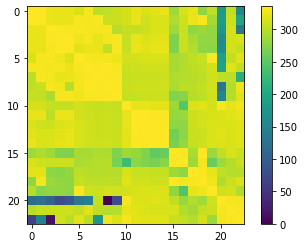

In [29]:
metric = np.abs(best_tmats)
metric = metric.sum(axis=(2,3))
metric = np.max(metric) - metric 
plt.imshow(metric)
plt.colorbar()

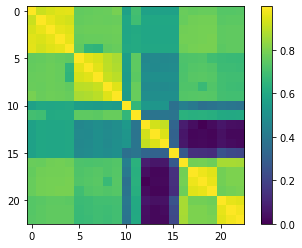

In [123]:
metric = (np.max(best_score)-best_score)/np.max(best_score)
plt.imshow(metric)
plt.colorbar()

In [62]:
results = pd.read_csv(path4results+"plotsregistration_logs.txt")

In [63]:
results.head()

,i,j,rigid_mean_enh,rigid_mean,affine_mean_enh,affine_mean,best_method
0,0,0.0000,0.0000,0.0000,0.0000,-,-
0,1,35.8685,35.3719,35.1389,34.6407,affine_mean,NaN
0,2,26.7687,26.7699,26.4963,26.3930,affine_mean,NaN
0,3,21.4373,21.2876,20.2543,20.0969,affine_mean,NaN
0,4,22.8805,22.4060,19.2165,18.7611,affine_mean,NaN


In [70]:
from numpy import genfromtxt
my_data = genfromtxt(path4results+"plotsregistration_ogs2.txt", delimiter=' ')

OSError: /media/andrey/My Passport/GITHUB_REPOS/Yang_Chini_et_al/notebooks/results/plotsregistration_ogs2.txt not found.

In [79]:
!conda install -c conda-forge imagehash --yes
#!pip install ImageHash #OR

Solving environment: done

## Package Plan ##

  environment location: /home/andrey/anaconda3

  added / updated specs:
    - imagehash


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    imagehash-4.2.0            |     pyhd8ed1ab_0         292 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         292 KB

The following NEW packages will be INSTALLED:

  imagehash          conda-forge/noarch::imagehash-4.2.0-pyhd8ed1ab_0



imagehash-4.2.0      | 292 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [99]:
from PIL import Image
import imagehash

cut = 100

image_similarity = np.zeros((np.shape(recordings)[0], np.shape(recordings)[0]))

for idx0 in range(np.shape(images_mean)[2]):            
    for idx1 in range(idx0, np.shape(images_mean)[2]):
        hash1=imagehash.average_hash(Image.fromarray(images_mean[cut:-cut, cut:-cut, idx0]))
        otherhash=imagehash.average_hash(Image.fromarray(images_mean[cut:-cut, cut:-cut, idx1]))
        image_similarity[idx0,idx1] = (hash1 - otherhash)
        image_similarity[idx1,idx0] = (hash1 - otherhash)    

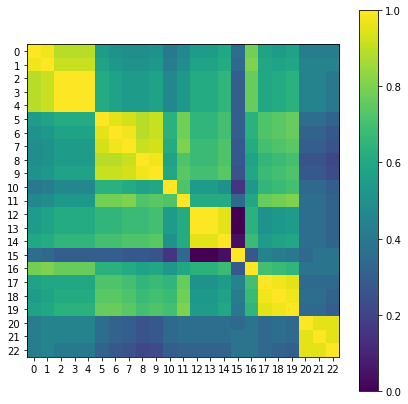

In [122]:
metric = (np.max(image_similarity)-image_similarity)/np.max(image_similarity)
fig, ax = plt.subplots(figsize=(7, 7))
plt.imshow(metric,extent=[-0.5,22.5,22.5,-0.5])
plt.colorbar()
plt.xticks(np.arange(0, np.shape(images_mean)[2], 1));
plt.yticks(np.arange(0, np.shape(images_mean)[2], 1));